# Explore Ranking Similarities

### Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

### Data Imports

In [19]:
df_track = pd.read_csv('../data/track.csv')
df_album = pd.read_csv('../data/album.csv')
df_artist = pd.read_csv('../data/artist.csv')
df = pd.read_csv('../data/rating.csv')
df_similar = pd.read_csv('../data/track_similarity.csv')
df_weekly_rating = pd.read_csv('../data/weekly_rating.csv')

### Functions Definitions

In [20]:
def get_artist_id(artist_name):
    return df_artist[df_artist['name'] == artist_name]['artist_id'].values[0]

def get_album_id(album_name):
    return df_album[df_album['name'] == album_name]['album_id'].values[0]

def get_track_id(track_name):
    return df_track[df_track['name'] == track_name]['track_id'].values[0]

# ====================================================

def get_all_tracks_by_artist(artist_id, only_id=False):
    return df_track[df_track['artist_id'] == artist_id] if not only_id else df_track[df_track['artist_id'] == artist_id]['track_id']

def get_all_tracks_by_album(album_id, only_id=False):
    return df_track[df_track['album_id'] == album_id] if not only_id else df_track[df_track['album_id'] == album_id]['track_id']

def get_all_albums_by_artist(artist_id, only_id=False):
    return df_album[df_album['artist_id'] == artist_id] if not only_id else df_album[df_album['artist_id'] == artist_id]['album_id']

# ====================================================

def convert_track_id_to_name(track_id):
    return df_track[df_track['track_id'] == track_id]['name'].values[0]

def convert_album_id_to_name(album_id):
    return df_album[df_album['album_id'] == album_id]['name'].values[0]

def convert_artist_id_to_name(artist_id):
    return df_artist[df_artist['artist_id'] == artist_id]['name'].values[0]

# ====================================================

def compare_track_lists_sim(track_id_list_1, track_id_list_2):

    ret_list = []

    for main_track_id in track_id_list_1:
        for other_track_id in track_id_list_2:    
            
            similarity = df_similar[(df_similar['track_id_1'] == main_track_id) & (df_similar['track_id_2'] == other_track_id)]
            
            if not similarity.empty:
                name1 = convert_track_id_to_name(main_track_id)
                name2 = convert_track_id_to_name(other_track_id)
                ret_list.append((name1, name2, float(similarity.iloc[0]["sim_degree"])))

            similarity = df_similar[(df_similar['track_id_2'] == main_track_id) & (df_similar['track_id_1'] == other_track_id)]
            
            if not similarity.empty:
                name1 = convert_track_id_to_name(main_track_id)
                name2 = convert_track_id_to_name(other_track_id)
                ret_list.append((name1, name2, float(similarity.iloc[0]["sim_degree"])))

    ret = sorted(ret_list, key=lambda x: x[2], reverse=True)
    return ret

## Ranking Sources Comparision

### By Average Rank of Track

In [21]:
def process_ratings():
    df = pd.read_csv('../data/rating.csv')

    # Convert the original 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract year and month, and set day as the first day of the month
    df['date'] = pd.to_datetime(df['date'].dt.strftime('%Y'))
    df['date'] = df['date'].dt.to_period('Y')

    print(df.shape)

    # Group by track_id and the modified date column (year-month) and calculate the mean
    df_new = (
        df.groupby(['track_id', 'date'], as_index=False)
        .mean(numeric_only=True)
        .round(0)
    )

    print(df_new.shape)

    # Compare the sparsity of the original and new data
    print('Original data sparsity:', df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))
    print('New data sparsity:', df_new.isnull().sum().sum() / (df_new.shape[0] * df_new.shape[1]))

    df = df_new
    df.head(10)

    return df

df = process_ratings()

(105511, 10)
(11756, 10)
Original data sparsity: 0.5488413530342808
New data sparsity: 0.5243875467846206


In [22]:
# Ensure rankings are numeric
columns_to_numeric = ['position_lastfm', 'position_spotify', 'position_billboard']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

df = df.drop(columns=['no_of_listeners_lastfm', 'no_of_listeners_spotify'])
df = df.dropna()

print('Rating dataframe shape:', df.shape)
print('Number of distinct tracks:', len(df['track_id'].unique()))

df.head(10)

Rating dataframe shape: (145, 8)
Number of distinct tracks: 127


,track_id,date,position_lastfm,time_epoch_x,position_spotify,time_epoch_y,position_billboard,time_epoch
4,3,2014,34.0,563.0,7.0,568.0,41.0,564.0
6,4,2014,45.0,571.0,17.0,568.0,55.0,568.0
8,5,2014,46.0,568.0,8.0,566.0,32.0,565.0
12,7,2014,66.0,569.0,11.0,568.0,32.0,566.0
16,9,2014,17.0,564.0,4.0,562.0,3.0,565.0
18,10,2014,33.0,562.0,10.0,562.0,9.0,562.0
20,11,2014,58.0,563.0,9.0,564.0,23.0,565.0
24,13,2014,47.0,570.0,16.0,570.0,17.0,570.0
28,15,2014,78.0,562.0,30.0,566.0,35.0,566.0
40,21,2014,27.0,561.0,6.0,562.0,21.0,555.0


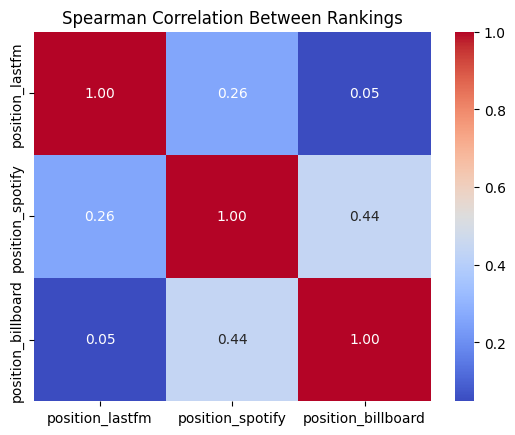

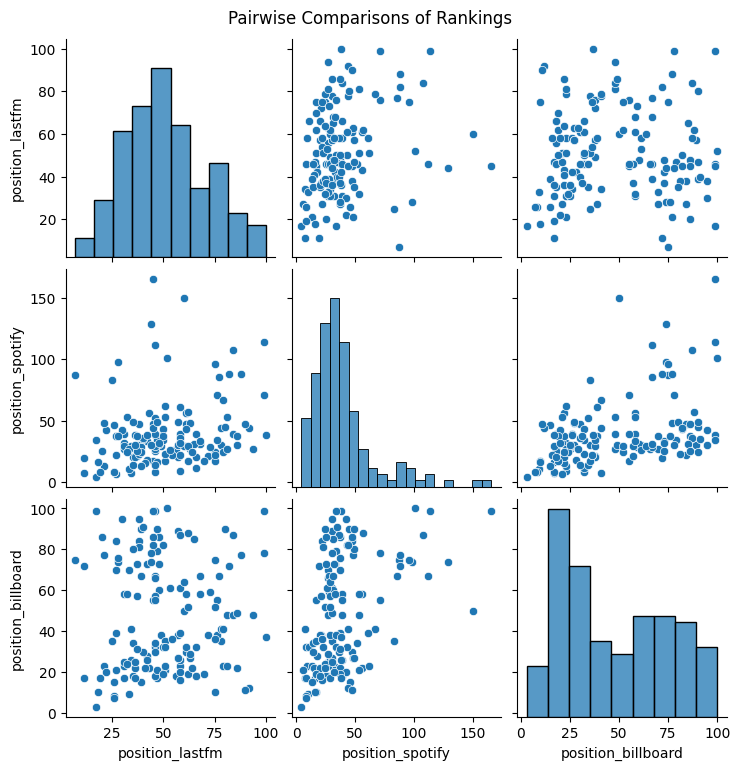

In [23]:
# Compute pairwise Spearman correlations
correlations = df[columns_to_numeric].corr(method='spearman')
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Between Rankings')
plt.show()

# Scatter plots to check for relationships
sns.pairplot(df, vars=columns_to_numeric)
plt.suptitle("Pairwise Comparisons of Rankings", y=1.02)
plt.show()

In [24]:
df = process_ratings()

# Ensure rankings are numeric
columns_to_numeric = ['no_of_listeners_lastfm', 'no_of_listeners_spotify']
df[columns_to_numeric] = df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

df = df.drop(columns=['position_lastfm', 'position_spotify', 'position_billboard'])
df = df.dropna()

print('Rating dataframe shape:', df.shape)
print('Number of distinct tracks:', len(df['track_id'].unique()))

df.head(10)

(105511, 10)
(11756, 10)
Original data sparsity: 0.5488413530342808
New data sparsity: 0.5243875467846206
Rating dataframe shape: (145, 7)
Number of distinct tracks: 127


,track_id,date,no_of_listeners_lastfm,time_epoch_x,no_of_listeners_spotify,time_epoch_y,time_epoch
4,3,2014,2774.0,563.0,2912855.0,568.0,564.0
6,4,2014,1787.0,571.0,2013722.0,568.0,568.0
8,5,2014,1927.0,568.0,2126197.0,566.0,565.0
12,7,2014,1599.0,569.0,1931628.0,568.0,566.0
16,9,2014,3419.0,564.0,3256386.0,562.0,565.0
18,10,2014,2406.0,562.0,2227387.0,562.0,562.0
20,11,2014,1821.0,563.0,2019324.0,564.0,565.0
24,13,2014,1653.0,570.0,1879094.0,570.0,570.0
28,15,2014,1616.0,562.0,1241468.0,566.0,566.0
40,21,2014,2496.0,561.0,2286016.0,562.0,555.0


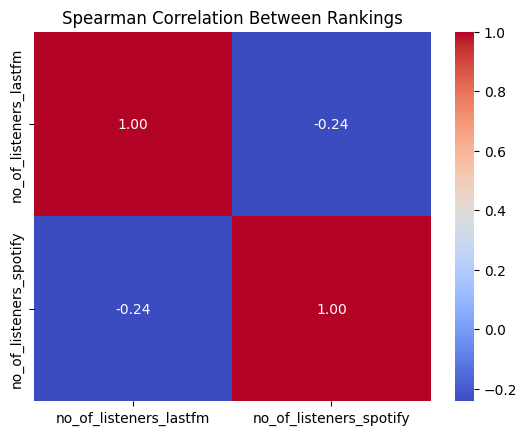

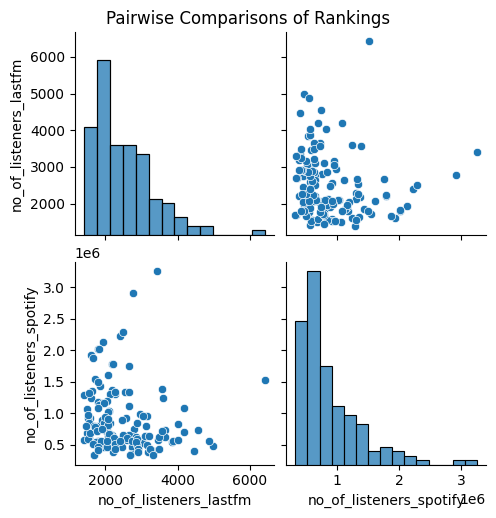

In [25]:
# Compute pairwise Spearman correlations
correlations = df[columns_to_numeric].corr(method='spearman')
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation Between Rankings')
plt.show()

# Scatter plots to check for relationships
sns.pairplot(df, vars=columns_to_numeric)
plt.suptitle("Pairwise Comparisons of Rankings", y=1.02)
plt.show()

### By Weekly Rank of Track in 2013-2014

In [26]:
# Get the year dataframe, which is from weekly_rating, get all rows that have time_epoch >= 487 and time_epoch <= 539, so between 29/04/2013 and 04/05/2014
df_year = df_weekly_rating[(df_weekly_rating['time_epoch'] >= 487) & (df_weekly_rating['time_epoch'] <= 539)]
df_year.shape
df = process_ratings()


(105511, 10)
(11756, 10)
Original data sparsity: 0.5488413530342808
New data sparsity: 0.5243875467846206


In [27]:
# Detect which track has the highest correlation between the three positions, using spearman correlation, and only using rows where both positions are not NaN
track_ids = df_year['track_id'].unique()

# Create a list to store the correlations
correlations = []

# Iterate over the track ids
for track_id in track_ids:
    # Get the track data
    df_year_single = df_year[df_year['track_id'] == track_id]
    billboard_spotify_filtered = df_year_single.dropna(subset=['position_billboard','position_spotify'],how='any')
    billboard_lastfm_filtered = df_year_single.dropna(subset=['position_billboard','position_lastfm'],how='any')
    spotify_lastfm_filtered = df_year_single.dropna(subset=['position_spotify','position_lastfm'],how='any')
    # Calculate the correlation between the positions, but use only the rows where both positions are not NaN
    corr_billboard_spotify, _ = spearmanr(billboard_spotify_filtered['position_billboard'], billboard_spotify_filtered['position_spotify'])
    corr_billboard_lastfm, _ = spearmanr(billboard_lastfm_filtered['position_billboard'], billboard_lastfm_filtered['position_lastfm'])
    corr_spotify_lastfm, _ = spearmanr(spotify_lastfm_filtered['position_spotify'], spotify_lastfm_filtered['position_lastfm'])
    # Save the correlations
    correlations.append((track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm))

# Replace NaN values in each correlation with 0
correlations = [(track_id, corr_billboard_spotify if not np.isnan(corr_billboard_spotify) else 0, corr_billboard_lastfm if not np.isnan(corr_billboard_lastfm) else 0, corr_spotify_lastfm if not np.isnan(corr_spotify_lastfm) else 0) for track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm in correlations]

/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_2310/2213737732.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_billboard_lastfm, _ = spearmanr(billboard_lastfm_filtered['position_billboard'], billboard_lastfm_filtered['position_lastfm'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_2310/2213737732.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_billboard_spotify, _ = spearmanr(billboard_spotify_filtered['position_billboard'], billboard_spotify_filtered['position_spotify'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_2310/2213737732.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_spotify_lastfm, _ = spearmanr(spotify_lastfm_filtered['position_spotify'], spotify_lastfm_filtered['position_lastfm'])
/var/folders/9v/pq5f14gd5g504dyqx5qzf5p00000gn/T/ipykernel_2310/2213737732

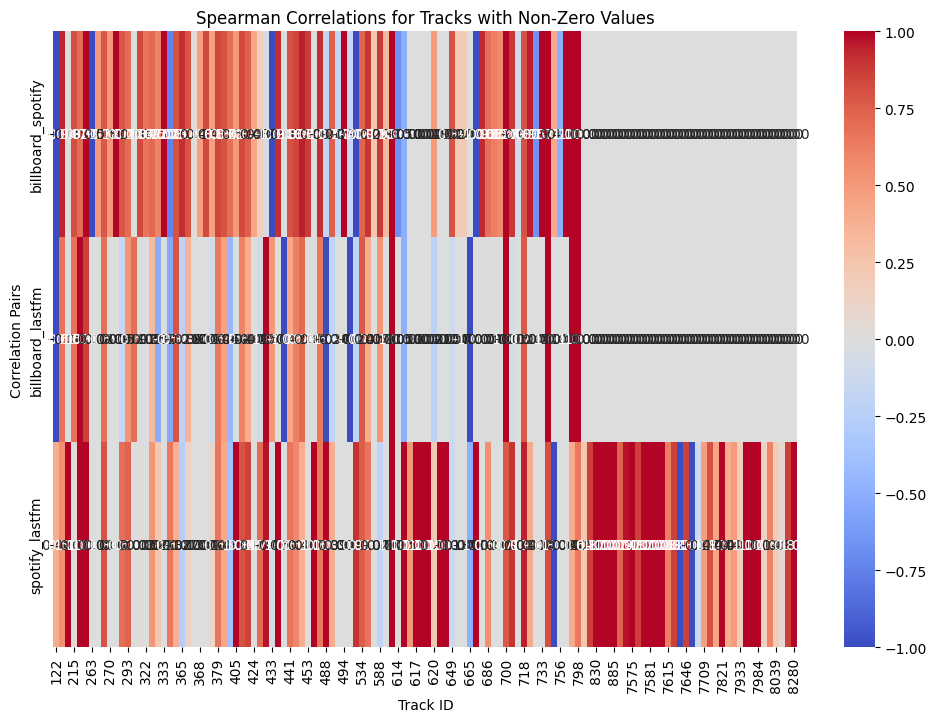

In [28]:
# Convert correlations list into a DataFrame
correlations = sorted(correlations, key=lambda x: x[0], reverse=False)
correlations_df = pd.DataFrame(correlations, columns=['track_id', 'billboard_spotify', 'billboard_lastfm', 'spotify_lastfm'])
# Filter out tracks with all correlation values equal to 0
correlations_df_filtered = correlations_df[
    ~((correlations_df['billboard_spotify'] == 0) & 
      (correlations_df['billboard_lastfm'] == 0) & 
      (correlations_df['spotify_lastfm'] == 0))
]

# Plot heatmap for the filtered data
plt.figure(figsize=(12, 8))
sns.heatmap(correlations_df_filtered.set_index('track_id').transpose(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlations for Tracks with Non-Zero Values')
plt.xlabel('Track ID')
plt.ylabel('Correlation Pairs')
plt.show()

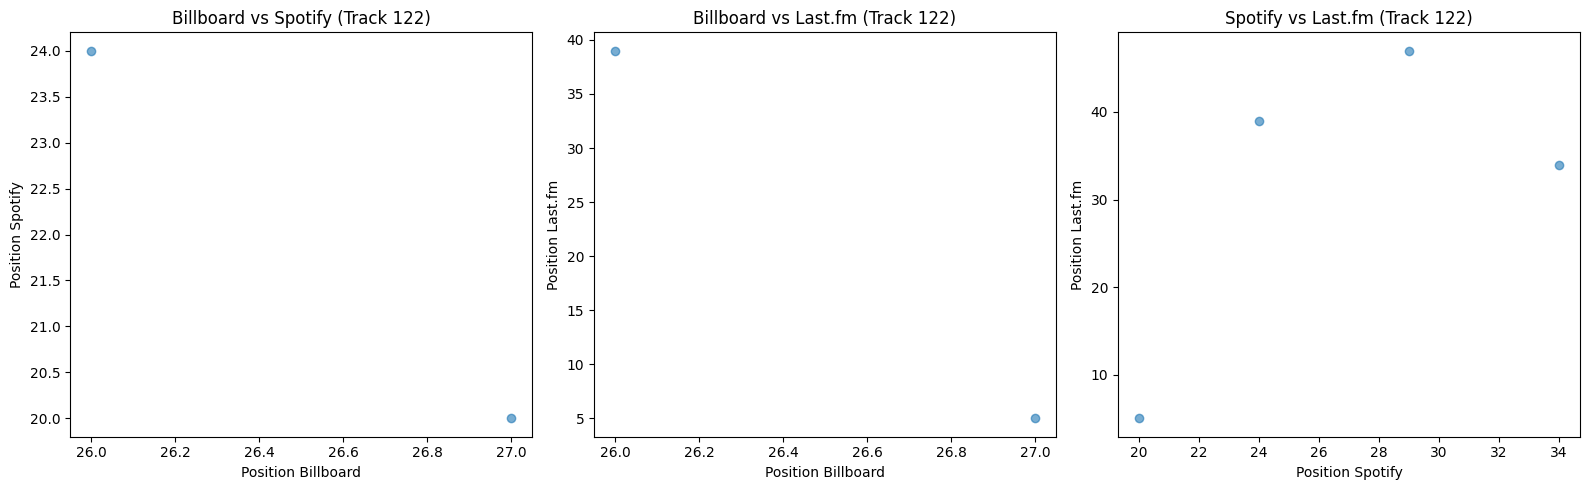

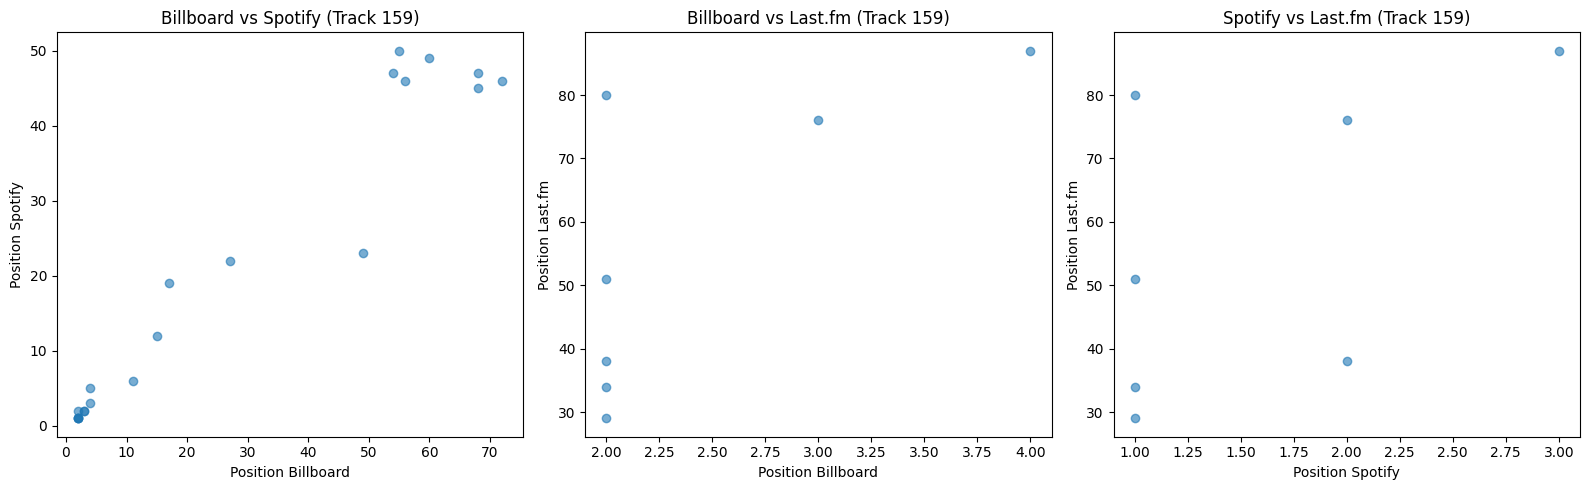

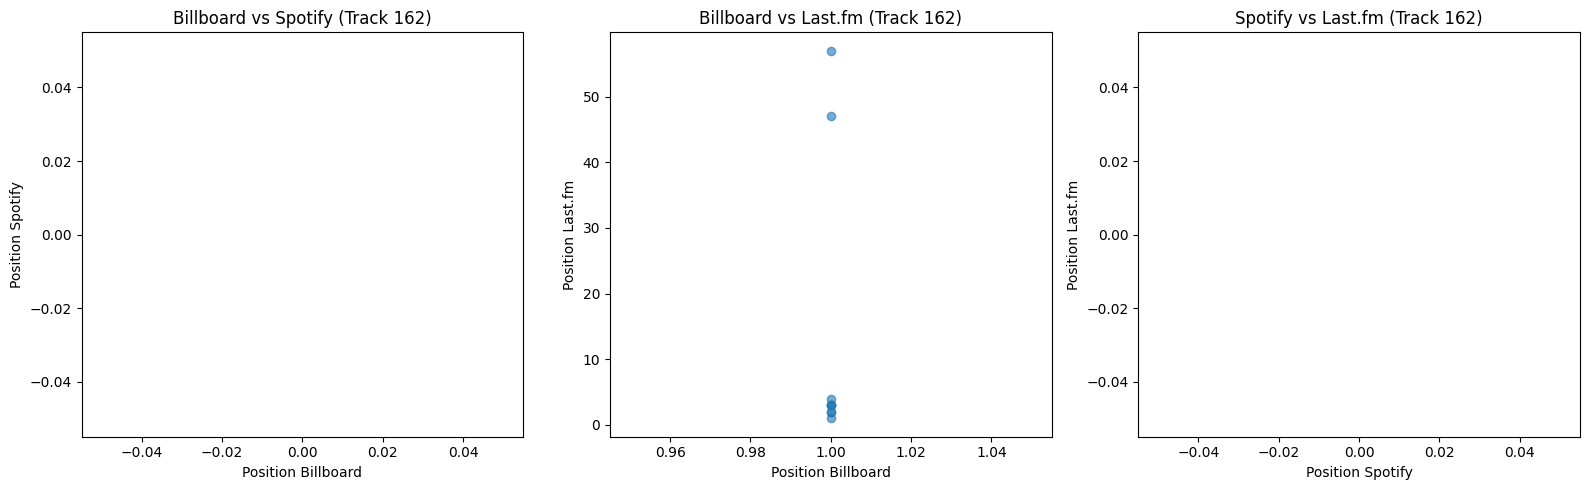

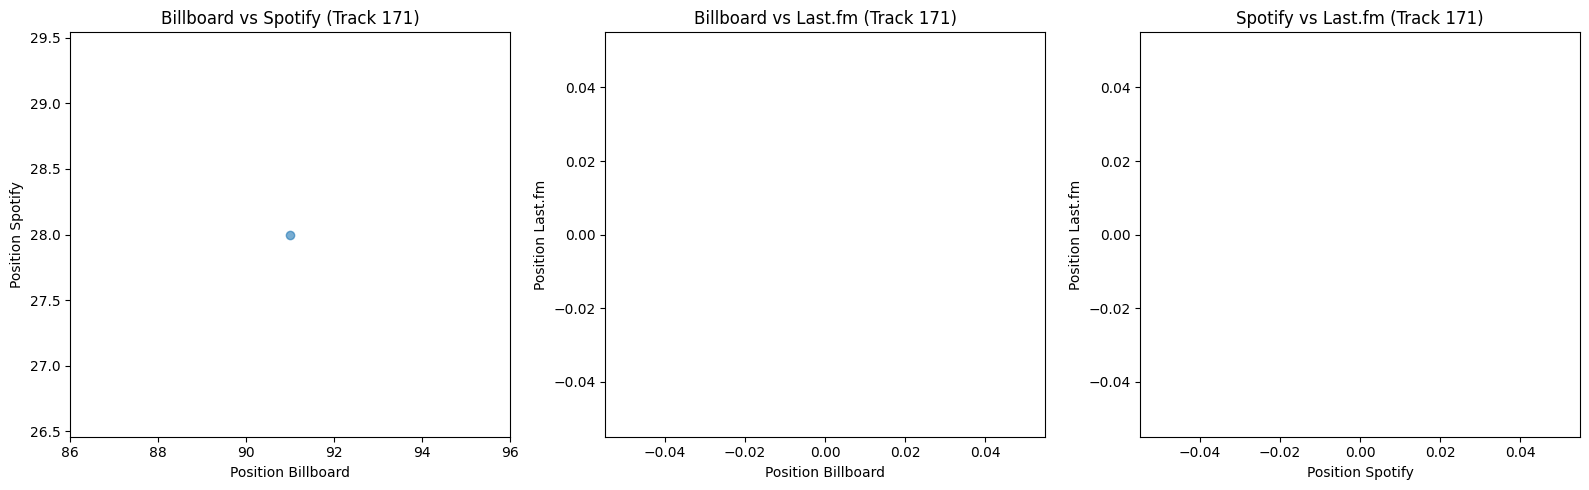

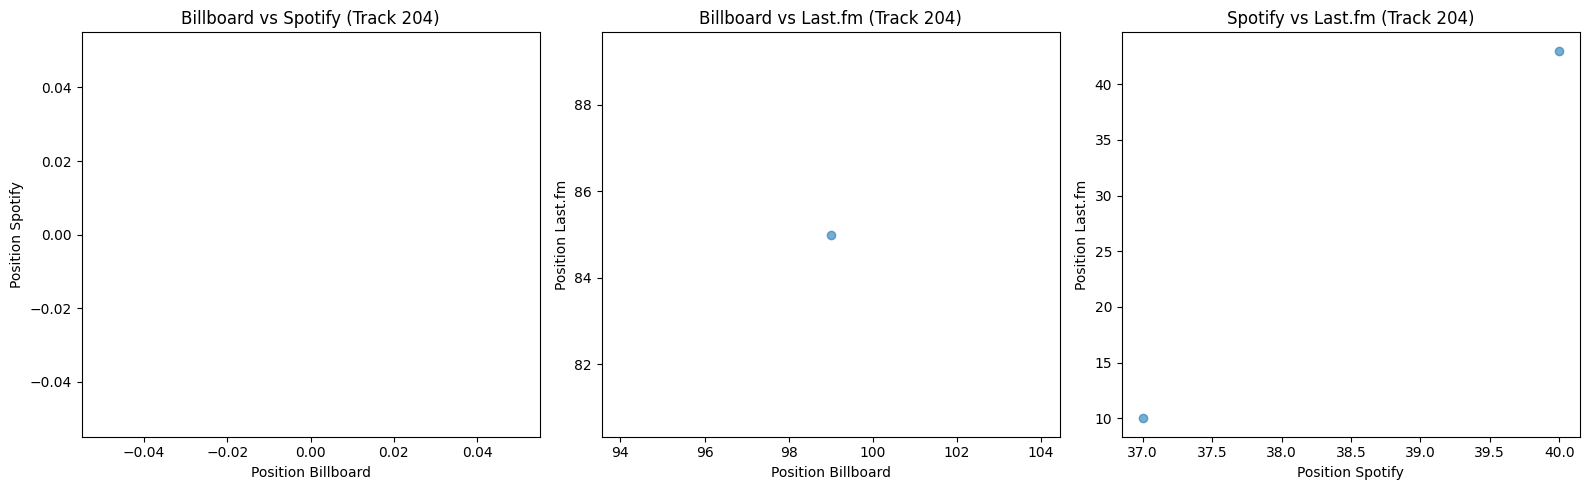

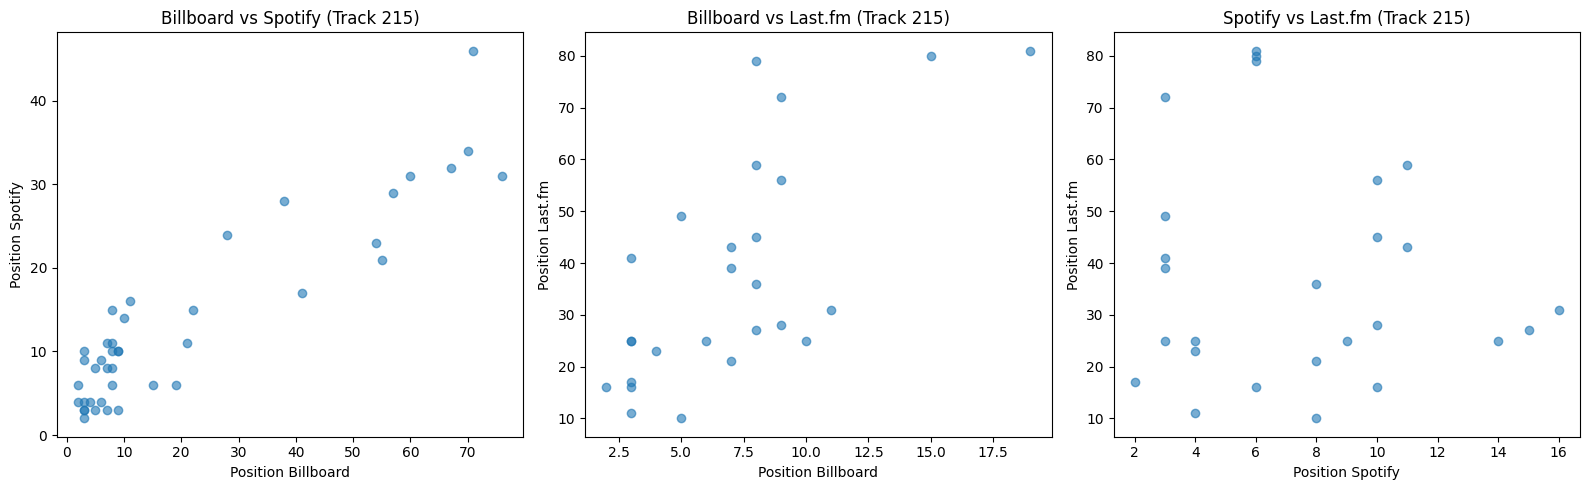

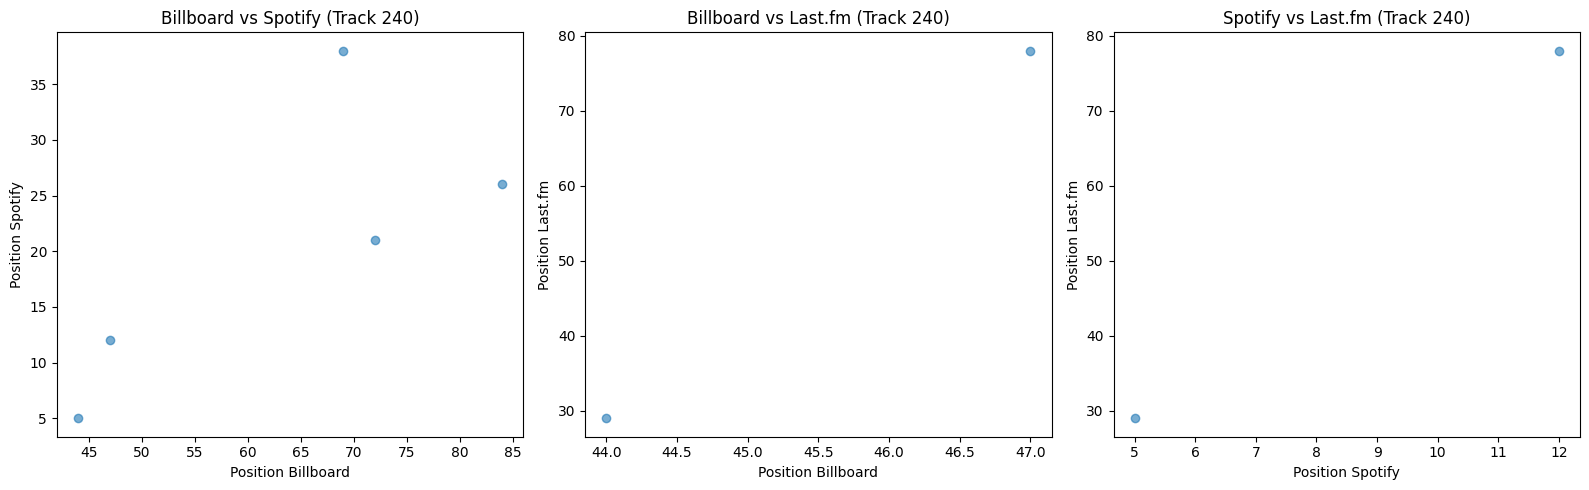

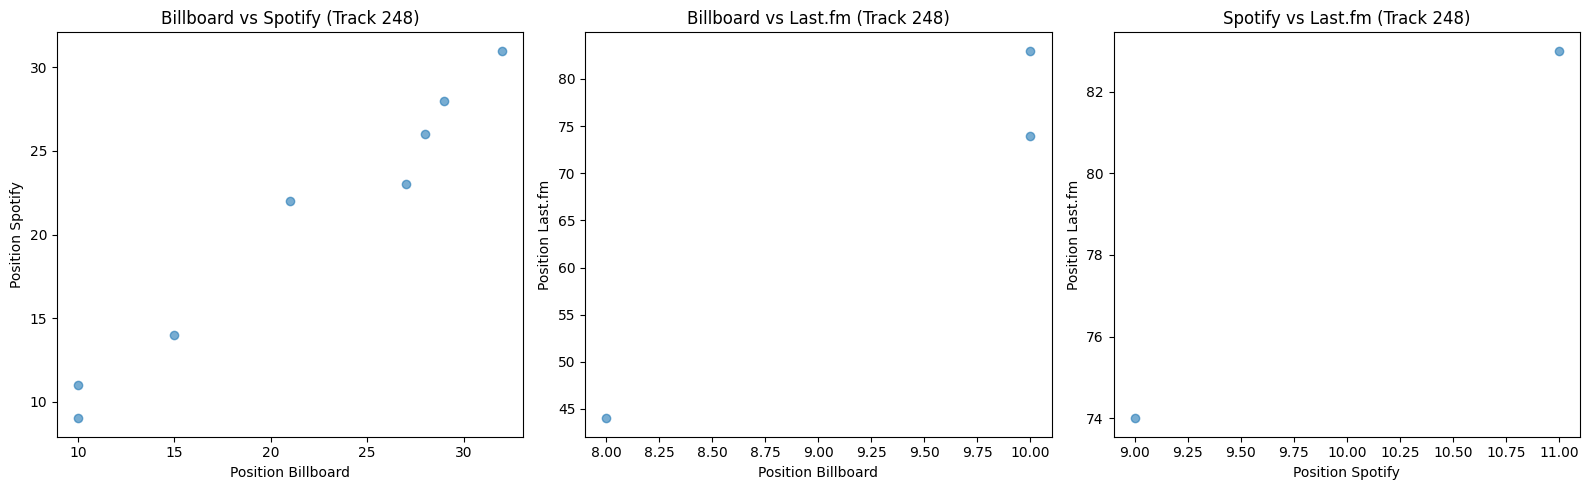

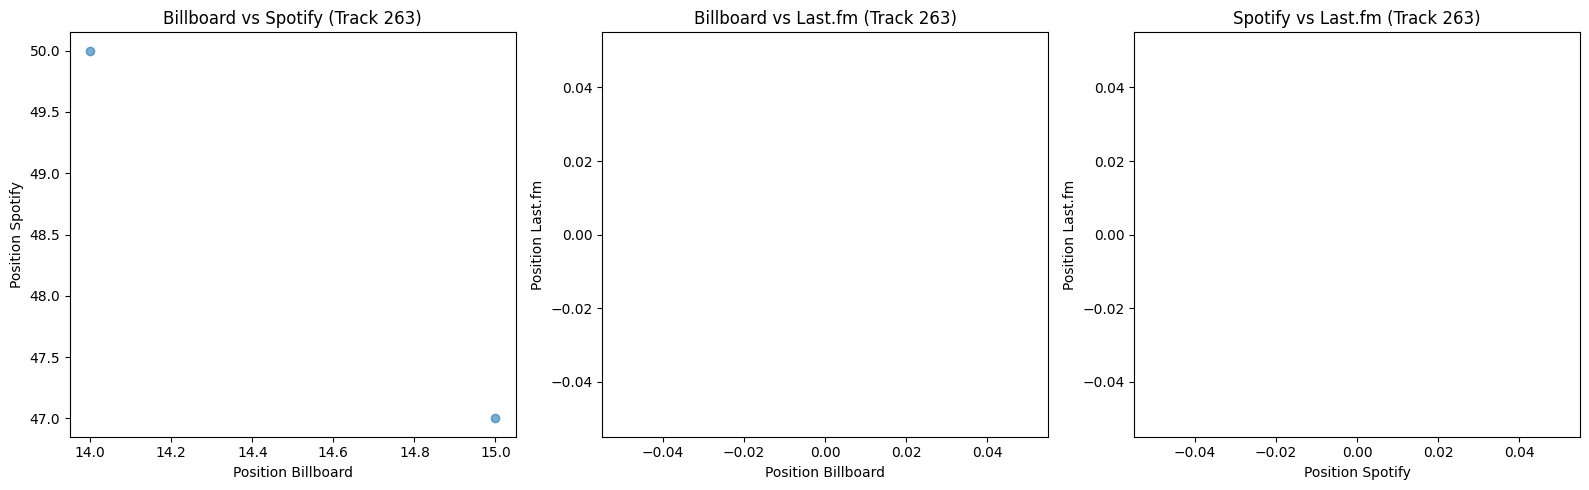

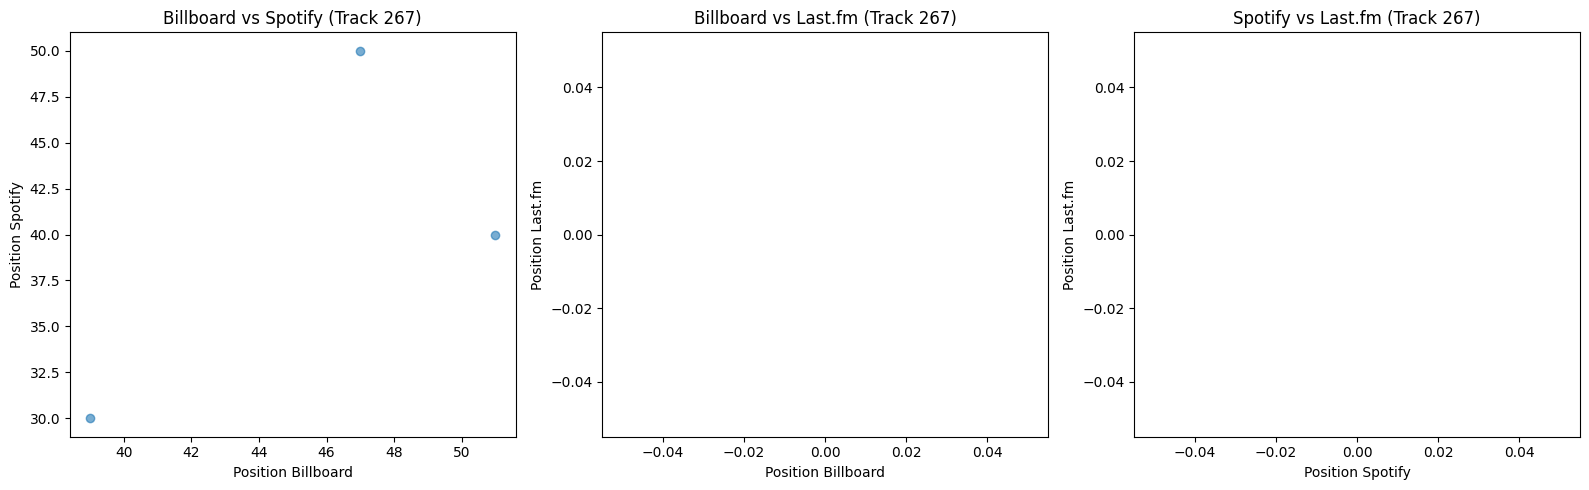

In [29]:
graphics = 10
for track_id in track_ids:
    df_year_single = df_year[df_year['track_id'] == track_id]
    
    # Filter for non-NaN pairs
    billboard_spotify = df_year_single.dropna(subset=['position_billboard', 'position_spotify'])
    billboard_lastfm = df_year_single.dropna(subset=['position_billboard', 'position_lastfm'])
    spotify_lastfm = df_year_single.dropna(subset=['position_spotify', 'position_lastfm'])
    if billboard_spotify.empty and billboard_lastfm.empty and spotify_lastfm.empty:
        continue
    else:
        graphics -= 1
        if graphics < 0:
            break
    # Create scatter plots
    plt.figure(figsize=(16, 5))
    
    # Billboard vs Spotify
    plt.subplot(1, 3, 1)
    plt.scatter(billboard_spotify['position_billboard'], billboard_spotify['position_spotify'], alpha=0.6)
    plt.title(f'Billboard vs Spotify (Track {track_id})')
    plt.xlabel('Position Billboard')
    plt.ylabel('Position Spotify')
    
    # Billboard vs Last.fm
    plt.subplot(1, 3, 2)
    plt.scatter(billboard_lastfm['position_billboard'], billboard_lastfm['position_lastfm'], alpha=0.6)
    plt.title(f'Billboard vs Last.fm (Track {track_id})')
    plt.xlabel('Position Billboard')
    plt.ylabel('Position Last.fm')
    
    # Spotify vs Last.fm
    plt.subplot(1, 3, 3)
    plt.scatter(spotify_lastfm['position_spotify'], spotify_lastfm['position_lastfm'], alpha=0.6)
    plt.title(f'Spotify vs Last.fm (Track {track_id})')
    plt.xlabel('Position Spotify')
    plt.ylabel('Position Last.fm')
    
    plt.tight_layout()
    plt.show()

In [30]:
# Correlations for billboard and spotify

# Sort the correlations
correlations = sorted(correlations, key=lambda x: x[1], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
#print(df_track)
print(f'Track with highest correlation between Billboard and Spotify: {convert_track_id_to_name(best_track_id), corr_billboard_spotify}')

Track with highest correlation between Billboard and Spotify: ('Not A Bad Thing', np.float64(1.0))


In [31]:
# Correlations for billboard and lastfm

# Sort the correlations
correlations = sorted(correlations, key=lambda x: x[2], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
print(f'Track with highest correlation between Billboard and LastFM: {convert_track_id_to_name(best_track_id), corr_billboard_lastfm}')

Track with highest correlation between Billboard and LastFM: ('I Will Wait', np.float64(1.0))


In [32]:
# Correlations for spotify and lastfm

# Sort the correlations
correlations = sorted(correlations, key=lambda x: x[3], reverse=True)
# Get the track with the highest correlation
best_track_id, corr_billboard_spotify, corr_billboard_lastfm, corr_spotify_lastfm = correlations[0]
# Print the results
print(f'Track with highest correlation between Spotify and LastFM: {convert_track_id_to_name(best_track_id), corr_spotify_lastfm}')

Track with highest correlation between Spotify and LastFM: ('Furthest Thing', np.float64(1.0))


In [33]:
# Create average of each column as a variable, using df mean
average_billboard_spotify = df['position_billboard'].corr(df['position_spotify'])
average_billboard_lastfm = df['position_billboard'].corr(df['position_lastfm'])
average_spotify_lastfm = df['position_spotify'].corr(df['position_lastfm'])

print(average_billboard_lastfm)
print(average_billboard_spotify)
print(average_spotify_lastfm)

# Create average of each column as a variable, using np.mean
average_billboard_spotify = np.mean([corr_billboard_spotify for _, corr_billboard_spotify, _, _ in correlations if corr_billboard_spotify != 0])
average_billboard_lastfm = np.mean([corr_billboard_lastfm for _, _, corr_billboard_lastfm, _ in correlations if corr_billboard_lastfm != 0])
average_spotify_lastfm = np.mean([corr_spotify_lastfm for _, _, _, corr_spotify_lastfm in correlations if corr_spotify_lastfm != 0])

print(average_billboard_lastfm)
print(average_billboard_spotify)
print(average_spotify_lastfm)

# Create graphic with the averages
#plt.figure(figsize=(12, 8))
#plt.bar(['Billboard vs Spotify', 'Billboard vs LastFM', 'Spotify vs LastFM'], [average_billboard_spotify, average_billboard_lastfm, average_spotify_lastfm])
#plt.title('Average Correlation Between Rankings')
#plt.ylabel('Average Correlation')
#plt.show()



-0.019384183090876105
0.4215147296815253
0.16479507847774155
0.239792512110537
0.477340293411493
0.5872955593755141


In [ ]:
columns = ['position_billboard', 'position_spotify', 'position_lastfm']


# Create a grid for scatter plots
fig, axes = plt.subplots(len(columns), len(columns), figsize=(12, 12))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Plot histogram on the diagonal
            axes[i, j].hist(df_year[col1].dropna(), bins=20, alpha=0.6, color='gray')
            axes[i, j].set_title(col1)
        else:
            # Scatter plot for non-NaN values for the specific pair of columns
            subset = df_year.dropna(subset=[col1, col2])
            x = subset[col1]
            y = subset[col2]
            
            # Scatter plot
            axes[i, j].scatter(x, y, alpha=0.6)
            
            # Calculate the line of best fit
            slope, intercept = np.polyfit(x, y, 2)
            line_x = np.linspace(x.min(), x.max(), 100)
            line_y = slope * line_x + intercept
            
            # Plot the line of best fit
            axes[i, j].plot(line_x, line_y, color='red', linestyle='--')
            
            axes[i, j].set_xlabel(col1)
            axes[i, j].set_ylabel(col2)

plt.tight_layout()
plt.suptitle("Pairwise Comparisons of Rankings with Line Adjustments", y=1.02)
plt.show()
